In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import datetime as dt
from dateutil.relativedelta import relativedelta
import sys
import pyodbc
import sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
metal = "Palladium"

In [3]:
# inputs = pd.read_csv('../data/csv/Gold_Data.csv')
# training_set = inputs[['Money Manager Shorts', 'Money Manager Longs', 'Ten_Yr_Futures_Settle', 'USD_Change']]
# training_set_y = inputs[['Gold_Settle']]

In [4]:
df = pd.read_csv(f"../data/csv/{metal}_Data.csv",index_col="Business_Week")
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[9],axis=1)
df = df.dropna(axis=1)
# Makes graphs easier to interpret and match up. This is unimportent for
# this model.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df["Date"])):
    if df["Date"][i].weekday() != 1:
#         print(df["Date"][i])
        try:
            df.at[i,"Date"] = df["Date"][i-1]+timedelta(days=7)
#             print(df["Date"][i])
#             print(df["Date"][i].weekday())
        except:
            df.at[i,"Date"] = df["Date"][i+1]-timedelta(days=7)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")
df = df.dropna()

In [5]:
df.head()


,Palladium_Settle,Palladium_Volume,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Date,,,,,,,,,,,,,,,,
2006-06-13,312.540000,218.600000,14355.0,1686.0,5375.0,891.0,7083.0,105.86250,34971.6,1935826.00,1.760,85.7620,7364.2,38753.4,0.0760,6.7790
2006-06-20,296.800000,21.200000,13681.0,1545.0,5138.0,955.0,7358.0,105.01875,10278.8,2003874.80,0.013,86.2112,772.6,37679.6,0.1175,6.9283
2006-06-27,311.090000,22.000000,13149.0,2000.0,5360.0,881.0,7110.0,104.33125,547949.0,2151127.00,0.340,86.0000,5056.2,23433.4,0.1715,7.4125
2006-07-04,316.566667,722.666667,13423.0,2040.0,5734.0,871.0,7109.0,104.53125,663508.5,2168869.75,-1.300,85.2640,2935.2,19682.8,-0.2920,7.1685
2006-07-11,328.080000,721.200000,13895.0,2042.0,6219.0,848.0,7413.0,104.71250,791971.0,2154420.80,0.230,85.0220,2823.0,19415.6,0.0960,7.1820


In [6]:
scaler_body = MinMaxScaler()
scaler_gold = MinMaxScaler()
scaler_body.fit(df.drop(f"{metal}_Settle",axis=1))
scaler_gold.fit(pd.DataFrame(df[f"{metal}_Settle"]))
normalized_df = [list(x) for x in scaler_body.transform(df.drop(f"{metal}_Settle",axis=1))]
normalized_gold = [list(x) for x in scaler_gold.transform(pd.DataFrame(df[f"{metal}_Settle"]))]
for i in range(len(normalized_gold)):
    normalized_gold[i].extend(normalized_df[i])
normalized_df = pd.DataFrame(normalized_gold,index=df.index,columns=df.columns)
normalized_df.head()

,Palladium_Settle,Palladium_Volume,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,Ten_Yr_Futures_Prev. Day Open Interest,USD_Change,USD_Settle,USD_Volume,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle
Date,,,,,,,,,,,,,,,,
2006-06-13,0.101312,0.024872,0.084123,0.093948,0.095326,0.109963,0.055621,0.049919,0.008508,0.281443,0.787799,0.447752,0.078327,0.197709,0.459380,0.019160
2006-06-20,0.089964,0.002412,0.068070,0.081862,0.086172,0.120807,0.069719,0.022412,0.001683,0.301270,0.531603,0.462115,0.001387,0.189336,0.476894,0.033710
2006-06-27,0.100267,0.002503,0.055399,0.120864,0.094747,0.108268,0.057005,0.000000,0.150305,0.344174,0.579557,0.455362,0.051387,0.078247,0.499683,0.080899
2006-07-04,0.104215,0.082224,0.061925,0.124293,0.109193,0.106574,0.056954,0.006520,0.182248,0.349343,0.339053,0.431829,0.026630,0.049000,0.304073,0.057119
2006-07-11,0.112516,0.082057,0.073167,0.124464,0.127926,0.102677,0.072538,0.012429,0.217757,0.345133,0.563426,0.424091,0.025320,0.046916,0.467820,0.058435


In [7]:
X = normalized_df.drop(f"{metal}_Settle", axis=1)
y = normalized_df[f"{metal}_Settle"]

In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1)

In [9]:
RF_Model = RF(n_estimators = 250, random_state = 0)
RF_Model.fit(X_train.values, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [10]:
RF_Model.score(X_train, y_train)

0.9948109836349752

In [11]:
RF_Model.score(X_test, y_test)

0.9564353921696741

In [12]:
predictions = pd.DataFrame(RF_Model.predict(X_test),index=X_test.index)

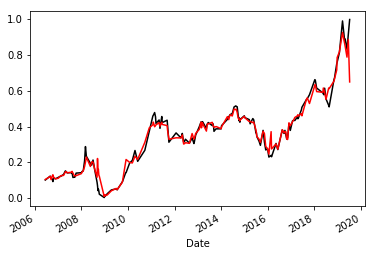

In [13]:
ax1 = y_test.plot(color="black")
ax2 = predictions[0].plot(color="red")

In [14]:
print('RMSE:', sqrt(mean_squared_error(y_test,predictions)))

RMSE: 0.0421403563099174


In [15]:
predictions_all = pd.DataFrame(RF_Model.predict(X),index=X.index)
predictions_all = pd.DataFrame(scaler_gold.inverse_transform(predictions_all),index=predictions_all.index)
predictions_all.columns = ["Relative Value"]
predictions_all = predictions_all.reset_index()
predictions_all.tail()

,Date,Relative Value
680,2019-06-25,1476.805520
681,2019-07-02,1450.930140
682,2019-07-09,1073.148052
683,2019-07-16,1305.033863
684,2019-07-23,1501.347320


In [16]:
daily_transform_url = f"../data/csv/{metal}Prices.csv"
daily = pd.read_csv(daily_transform_url)[["Date","Settle"]]
daily["Date"] = pd.to_datetime(daily["Date"],infer_datetime_format=True)
daily = daily.merge(predictions_all,on="Date",how="left")
daily = daily.fillna(method="bfill")
daily = daily.dropna()
for i in range(len(daily.index)-3):
    daily.at[i,"Relative Value"] = daily["Relative Value"][i+3]
daily = daily.iloc[:len(daily.index)-3]
daily.to_csv(f"../data/csv/{metal}_RF_Daily.csv",index=False)
daily.head(15)

,Date,Settle,Relative Value
0,2019-07-26,1531.0,1501.347320
1,2019-07-25,1533.9,1305.033863
2,2019-07-24,1538.5,1305.033863
3,2019-07-23,1518.6,1305.033863
4,2019-07-22,1529.2,1305.033863
5,2019-07-19,1508.3,1305.033863
6,2019-07-18,1511.9,1073.148052
7,2019-07-17,1543.2,1073.148052
8,2019-07-16,1516.3,1073.148052
9,2019-07-15,1562.9,1073.148052


In [17]:
# only_fridays = [i for i in range(0,len(daily.index)+1,5)]
#weekly = daily.iloc[only_fridays]
#daily.to_csv(f"../data/csv/{metal}_RF_Weekly.csv",index=False)
#weekly.head()

#only_fridays = [i for i in range(0,len(FinalPredict_DF2.index)+1,5)]
#weekly = FinalPredict_DF2.iloc[only_fridays]
#weekly.head(10)

weekly = daily.loc[[True if day.weekday() == 4 else False for day in daily["Date"]]]
weekly.head()

,Date,Settle,Relative Value
0,2019-07-26,1531.0,1501.347320
5,2019-07-19,1508.3,1305.033863
10,2019-07-12,1542.4,1073.148052
15,2019-07-05,1564.2,1476.805520
19,2019-06-28,1537.6,1476.805520


C:\Users\mtral\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mtral\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mtral\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

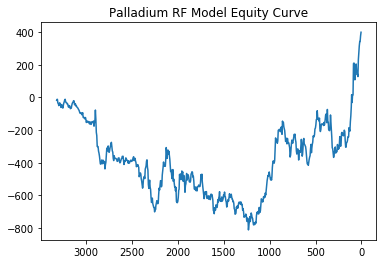

In [18]:
weekly['Settle Delta'] = weekly['Settle'].diff(+1)
weekly['Settle Delta'] = weekly['Settle Delta'].apply(lambda x:x*-1)
weekly['Rel Val Delta'] = weekly['Relative Value'].diff(-1)

Signal = np.sign(weekly['Rel Val Delta'])
weekly2 = pd.concat([weekly, pd.DataFrame(Signal)], axis=1)
weekly2.columns = ['Date', 'Settle', 'Relative Value', 'Settle Delta', 'Rel Val Delta', 'Signal']

weekly2['Profit'] = weekly2['Settle Delta']*weekly2['Signal']
weekly2['EC'] = weekly2.Profit[::-1].cumsum()
fig = plt.figure()
ax = weekly2['EC'].plot(title='Palladium RF Model Equity Curve')
ax.invert_xaxis()
fig.savefig('../graphs/PALLADIUM_RF.png')